In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, copy, os, shutil
from tqdm.notebook import tqdm
import seaborn as sns

In [173]:
# specify dimensions of our gridworld (presumably square)
d = 10

# color = how to make it R^3, does NOT affect geography, but gives signals that certain actions are safe.
# simple-english actions: EACH ACTION IS A TUPLE
action_descs = {(0, 0) : "stay", (0, 1) : "up", (1, 1) : "diag-right-up", (1, 0) : "right", 
                (1, -1): "diag-right-down", (0, -1) : "down", 
                (-1, -1) : "diag-left-down", (-1, 0) : "left", (-1, 1): "diag-left-up"}

# grid world (baseline)
gw0 = np.full(shape=(d, d), fill_value=-1.0); gw0[0, -1] = +10.0

# bridge grid world (no overflow)
gw1 = np.full(shape=(d, d), fill_value=-1.0); gw1[:, 5:8] = -10.0
gw1[6,:] = -1.0; gw1[6,4:9] = +1.0
gw1[0:3,:] = -1.0; gw1[6, -1] = +10.0

# bridge grid world (yes overflow)
gw2 = np.full(shape=(d, d), fill_value=-1.0); gw2[:, 4:9] = -10.0
gw2[6,:] = -1.0; gw2[6,4:9] = +1.0
gw2[0:3,:] = -1.0; gw2[6, -1] = +10.0

In [175]:
# function that governs which river state in: we have (slightly) stochastic rewards.
def get_environment(p_overflow):
    return gw1.copy() if np.random.uniform() < p_overflow else gw2.copy()

In [176]:
# function that returns reward
def get_reward(state, environment, noise):
    return environment[state[0], state[1]] + np.random.normal(loc=0.0, scale=noise)

<AxesSubplot:>

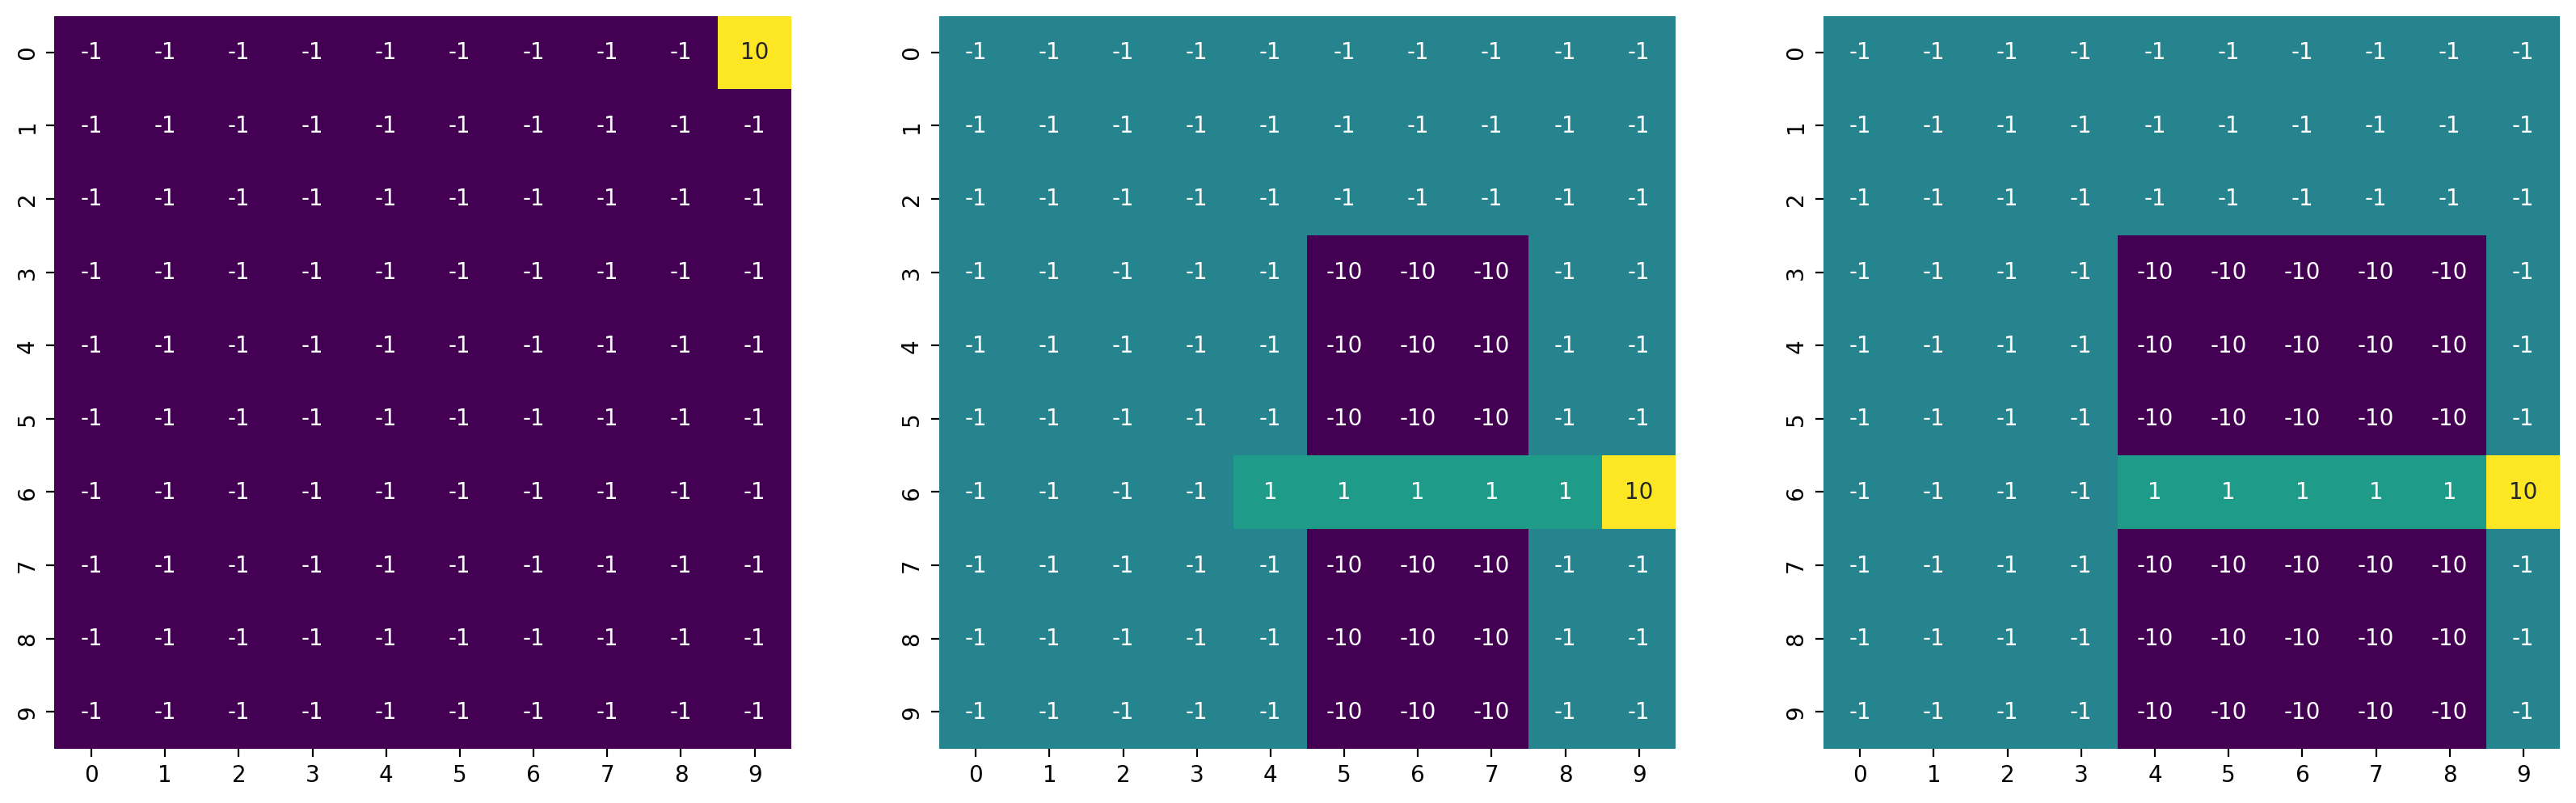

In [174]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 6))

# plot the baseline grid world
sns.heatmap(gw0, ax=ax[0], cmap="viridis", annot=True, cbar=False)

# plot the bridge grid world
sns.heatmap(gw1, ax=ax[1], cmap="viridis", annot=True, cbar=False)

# plot the bridge grid world
sns.heatmap(gw2, ax=ax[2], cmap="viridis", annot=True, cbar=False)

In [46]:
'''
# green: OK to go right from here; 
# orange: ur safe right now, but if you go right, bad OR ur bad right now, but go right = in a better place.
# red: ur in a bad place, and moving right will keep you in a bad place
# ambiguity in orange is intentional because you need to learn relationship between orange + (x,y)
'''
# encoding the colors as TRAFFIC SIGNALS!
def make_gw_colors(gw):

    # instantiate a color environment as all green.
    gw_colors = np.full(shape=(d,d), fill_value=0.0)

    # if-then rules for encoding colors
    for i in range(d):
        for j in range(d):

            # figure out what my location would be if I took a step right
            j_right = j+1 if j != d-1 else j

            # safe to go right: green
            if gw[i,j] >= -1 and gw[i,j_right] >= -1:
                gw1_colors[i,j] = 0
            elif gw[i,j] == -10 and gw[i,j_right] == -1:
                gw_colors[i,j] = 1
            elif gw[i,j] == -1 and gw[i,j_right] == -10:
                gw1_colors[i,j] = 1
            elif gw[i,j] == -10 and gw[i,j_right] == -10:
                gw_colors[i,j] = 2
                
    # return the colors
    return gw_colors

# make the color-grid for GridWorld1
gw1_colors = make_gw_colors(gw1)

In [ ]:
# account for the stochasticity of the water by having too

In [87]:
# a TRUE movement function, return the non-stochastic next state
def true_move(state, a, gw, gw_colors, phi_wind):
    
    # extract the state quantities
    i, j, c = tuple(state)
    
    # what's our proposed movement?
    i_new = int(np.clip(a=i-a[1], a_min=0, a_max=d-1))
    j_new = int(np.clip(a=j+a[0], a_min=0, a_max=d-1))
    
    # get our new color
    c_new = int(gw_colors[i_new, j_new])
    
    # compile + return the new state
    new_state = np.array([i_new, j_new, c_new])
    return new_state

In [ ]:
# to account for wind in both i and j directions
def wind(state, pwind_i, pwind_j):
    
    # make a copy of our state
    wind_state = state.copy()
    
    # determine our i direction perturbation
    if np.random.uniform() < pwind_i:
        wind_state[0] += np.random.choice([-1.0, 1.0])
        wind_state[0] = np.clip(a=wind_state[0], a_min=0, a_max=d-1)
        
    # independently, determine our j direction perturbation
    if np.random.uniform() < pwind_j:
        wind_state[1] += np.random.choice([-1.0, 1.0])
        wind_state[1] = np.clip(a=wind_state[1], a_min=0, a_max=d-1)
        
    # just return our state
    return wind_state

In [138]:
# first missing data function: can have DIFFERENT THETAS FOR EACH COMPONENT!
# case1: thetas all the same, case2: thetas different.
def MCAR(state, thetas):
    
    # make a copy to stay safe: "partially-observed state"
    po_state = state.copy().astype(float)
    
    # generate three bernoullis: theta is PROBABILITY OF BEING MISSING!
    mask = np.random.binomial(1, thetas).astype(bool)
    po_state[mask] = np.nan
    
    # return our missing-operated state
    return po_state

In [167]:
# a list of (theta_i, theta_j, theta_c) for each color c
# FILL IN THESE VALUES LATER.
thetas_MAR_dict = {0: np.array([]),
                   1: np.array([]),
                   2: np.array([])}


# learning x,y|c is MAR
# learning c|x,y is not MAR because if colors missing at different rates, 
# could skew our assessment of how likely color actually is for that x,y
# only really becomes more relevant when stochastic water so color is random
# second missing data function: different thetas for each color that we're currently in.
def Mcolor(state): # "partially-MAR"
    
    # query what our true color is + get the corresponding thetas_c vector
    c = int(state[2]); thetas_c = thetas_MAR_dict[c]
    
    # use MCAR
    return MCAR(state, thetas_c)

In [ ]:
# put "fog" in a region governed by {i_range x j_range}. If you are in that region, 
def Mfog(state, i_range, j_range, thetas_inregion, thetas_outregion):
    
    # default to not being in the region
    inregion = False
    
    # check if we're in the fog region or not
    if np.clip(a=state[0], a_min=i_range[0], a_max=i_range[1]) == state[0]:
        if np.clip(a=state[1], a_min=j_range[0], a_max=j_range[1]) == state[1]:
            inregion = True
            
    # figure out what thetas to use + apply the MCAR
    thetas = thetas_inregion if inregion else thetas_outregion
    po_state = MCAR(state, thetas)

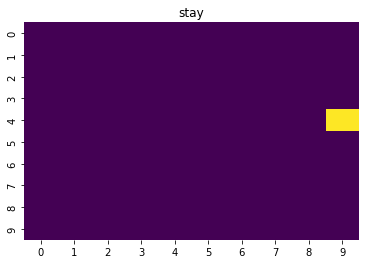

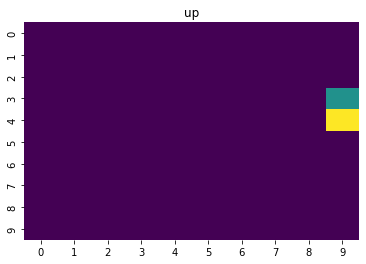

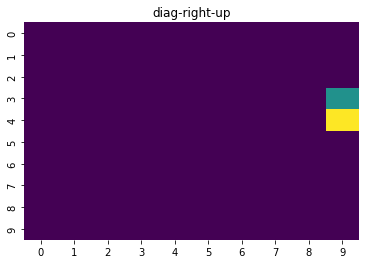

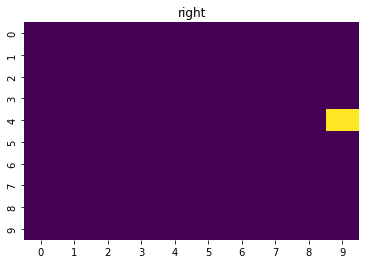

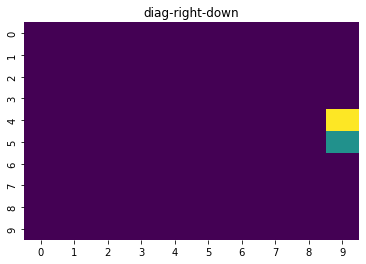

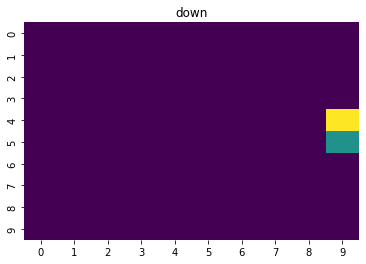

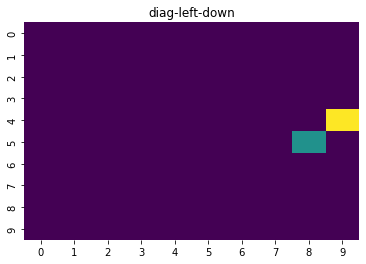

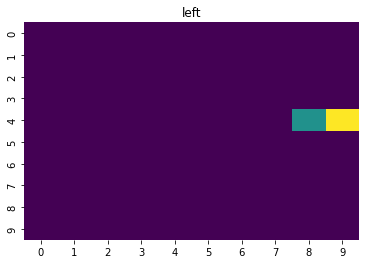

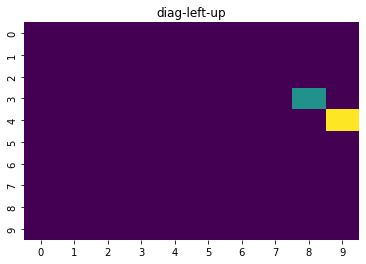

In [90]:
# try all possible actions
for a in list(action_descs.keys()):
    
    # try a test-case
    gw = np.zeros((d,d))

    # initialize our state randomly
    state = np.array([4, 9, 1])
    gw[state[0], state[1]] = +100
    
    # get our new state
    new_state = true_move(state, a, gw, gw1_colors)
    gw[new_state[0], new_state[1]] = 50
    
    sns.heatmap(gw, cbar=False, cmap="viridis")
    plt.title(action_descs[a])
    plt.show()